In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [ ]:
class GaussianMixtureDataset(Dataset):
    def __init__(self, n_samples=10000, centers=8, radius=2.0, std=0.05):
        super().__init__()
        samples = []
        for _ in range(n_samples):
            angle = np.random.randint(0, centers) * 2 * np.pi / centers
            center = np.array([radius * np.cos(angle), radius * np.sin(angle)])
            point = center + np.random.randn(2) * std
            samples.append(point)
        samples = np.array(samples, dtype=np.float32)
        self.samples = torch.from_numpy(samples)       

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

dataset = GaussianMixtureDataset(n_samples=10000)
loader = DataLoader(dataset, batch_size=512, shuffle=True)

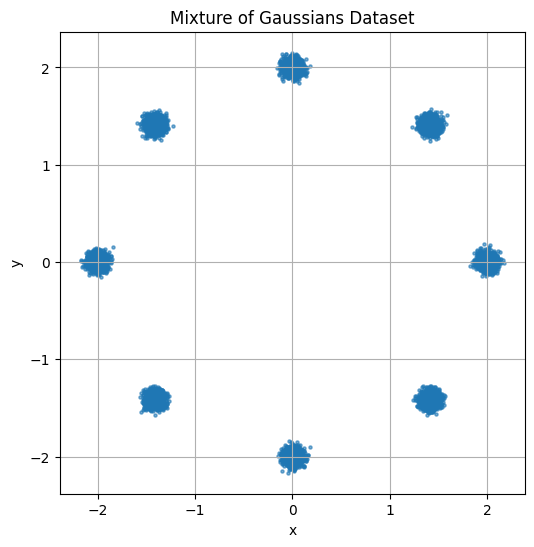

In [3]:
data = dataset[:].numpy()

plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=5, alpha=0.6)
plt.title("Mixture of Gaussians Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()


In [4]:
class MLP_G(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 2))

    def forward(self, z):
        return self.net(z)

class MLP_D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 1))

    def forward(self, x):
        return self.net(x)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_gan(G, D, loader, n_epochs=1000, latent_dim=2):
    optimizer_G = optim.Adam(G.parameters(), lr=1e-4)
    optimizer_D = optim.Adam(D.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    losses_G, losses_D = [], []
    samples_by_epoch = {}

    for epoch in range(1, n_epochs + 1):
        for real_samples in loader:
            real_samples = real_samples.to(device)
            batch_size = real_samples.size(0)
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_samples = G(z).detach()
            real_loss = criterion(D(real_samples), valid)
            fake_loss = criterion(D(fake_samples), fake)
            loss_D = (real_loss + fake_loss) / 2
            loss_D.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_samples = G(z)
            loss_G = criterion(D(gen_samples), valid)
            loss_G.backward()
            optimizer_G.step()

        losses_D.append(loss_D.item())
        losses_G.append(loss_G.item())

        if epoch % 10 == 0:
            print(f"[GAN] Epoch {epoch}/{n_epochs} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

        if epoch in [1, 10, 50, 100, 200, 500, 1000]:
            with torch.no_grad():
                z = torch.randn(1000, latent_dim).to(device)
                samples = G(z).cpu().numpy()
                samples_by_epoch[epoch] = samples

    return losses_G, losses_D, samples_by_epoch




def train_wgan(G, D, loader, n_epochs=1000, latent_dim=2, n_critic=5, clip_value=0.1):
    optimizer_G = optim.RMSprop(G.parameters(), lr=1e-4)
    optimizer_D = optim.RMSprop(D.parameters(), lr=1e-4)

    losses_G, losses_D = [], []
    samples_by_epoch = {}

    for epoch in range(1, n_epochs + 1):
        for i, real_samples in enumerate(loader):
            real_samples = real_samples.to(device)
            batch_size = real_samples.size(0)

            for _ in range(n_critic):
                optimizer_D.zero_grad()
                d_real = D(real_samples).mean()
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_samples = G(z).detach()
                d_fake = D(fake_samples).mean()
                loss_D = -(d_real - d_fake)
                loss_D.backward()
                optimizer_D.step()
                for p in D.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_samples = G(z)
            loss_G = -D(gen_samples).mean()
            loss_G.backward()
            optimizer_G.step()

        losses_D.append(loss_D.item())
        losses_G.append(loss_G.item())

        if epoch % 10 == 0:
            print(f"[WGAN] Epoch {epoch}/{n_epochs} | Critic Loss: {loss_D.item():.4f} | Generator Loss: {loss_G.item():.4f}")

        if epoch in [1, 10, 50, 100, 200, 500, 1000]:
            with torch.no_grad():
                z = torch.randn(1000, latent_dim).to(device)
                samples = G(z).cpu().numpy()
                samples_by_epoch[epoch] = samples

    return losses_G, losses_D, samples_by_epoch




In [6]:
def create_sample_evolution_figure(gan_samples, wgan_samples):
    """Create the sample evolution comparison figure"""
    fig = plt.figure(figsize=(20, 8))
    gs = GridSpec(2, 8, figure=fig)

    epochs = [1, 10, 50, 100, 200, 500, 1000]

    # ===== GAN Samples =====
    ax_gan_title = fig.add_subplot(gs[0, 0])
    ax_gan_title.axis('off')
    ax_gan_title.text(0.5, 0.5, 'GAN', ha='center', va='center',
                     fontsize=14, fontweight='bold')

    for i, epoch in enumerate(epochs, start=1):
        ax = fig.add_subplot(gs[0, i])
        samples = gan_samples.get(epoch)
        if samples is not None:
            ax.scatter(samples[:, 0], samples[:, 1], alpha=0.6,
                      color='blue', s=10)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_title(f'Epoch {epoch}')
        ax.grid(True)
        ax.set_xticks([])
        ax.set_yticks([])

    # ===== WGAN Samples =====
    ax_wgan_title = fig.add_subplot(gs[1, 0])
    ax_wgan_title.axis('off')
    ax_wgan_title.text(0.5, 0.5, 'WGAN', ha='center', va='center',
                      fontsize=14, fontweight='bold')

    for i, epoch in enumerate(epochs, start=1):
        ax = fig.add_subplot(gs[1, i])
        samples = wgan_samples.get(epoch)
        if samples is not None:
            ax.scatter(samples[:, 0], samples[:, 1], alpha=0.6,
                      color='orange', s=10)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_title(f'Epoch {epoch}')
        ax.grid(True)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.savefig('gan_wgan_sample_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_loss_curves(gan_losses, wgan_losses):
    """Plot the loss curves in side-by-side subplots"""
    plt.figure(figsize=(12, 5))

    # GAN Losses
    plt.subplot(1, 2, 1)
    plt.plot(gan_losses[0], label='Generator', color='blue')
    plt.plot(gan_losses[1], label='Discriminator', color='orange')
    plt.title('GAN Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # WGAN Losses
    plt.subplot(1, 2, 2)
    plt.plot(wgan_losses[0], label='Generator', color='blue')
    plt.plot(wgan_losses[1], label='Critic', color='orange')
    plt.title('WGAN Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('gan_wgan_loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()



[GAN] Epoch 10/1000 | D Loss: 0.6160 | G Loss: 0.9385
[GAN] Epoch 20/1000 | D Loss: 0.5843 | G Loss: 0.8730
[GAN] Epoch 30/1000 | D Loss: 0.4831 | G Loss: 1.4830
[GAN] Epoch 40/1000 | D Loss: 0.4553 | G Loss: 1.4424
[GAN] Epoch 50/1000 | D Loss: 0.5487 | G Loss: 1.2501
[GAN] Epoch 60/1000 | D Loss: 0.5476 | G Loss: 1.1037
[GAN] Epoch 70/1000 | D Loss: 0.4365 | G Loss: 1.0792
[GAN] Epoch 80/1000 | D Loss: 0.4439 | G Loss: 1.0369
[GAN] Epoch 90/1000 | D Loss: 0.4971 | G Loss: 1.1205
[GAN] Epoch 100/1000 | D Loss: 0.4933 | G Loss: 1.2606
[GAN] Epoch 110/1000 | D Loss: 0.5982 | G Loss: 0.9290
[GAN] Epoch 120/1000 | D Loss: 0.5808 | G Loss: 0.9143
[GAN] Epoch 130/1000 | D Loss: 0.5759 | G Loss: 0.8763
[GAN] Epoch 140/1000 | D Loss: 0.5613 | G Loss: 0.9052
[GAN] Epoch 150/1000 | D Loss: 0.5440 | G Loss: 0.9850
[GAN] Epoch 160/1000 | D Loss: 0.5111 | G Loss: 1.0648
[GAN] Epoch 170/1000 | D Loss: 0.5010 | G Loss: 1.1546
[GAN] Epoch 180/1000 | D Loss: 0.4868 | G Loss: 1.1630
[GAN] Epoch 190/100

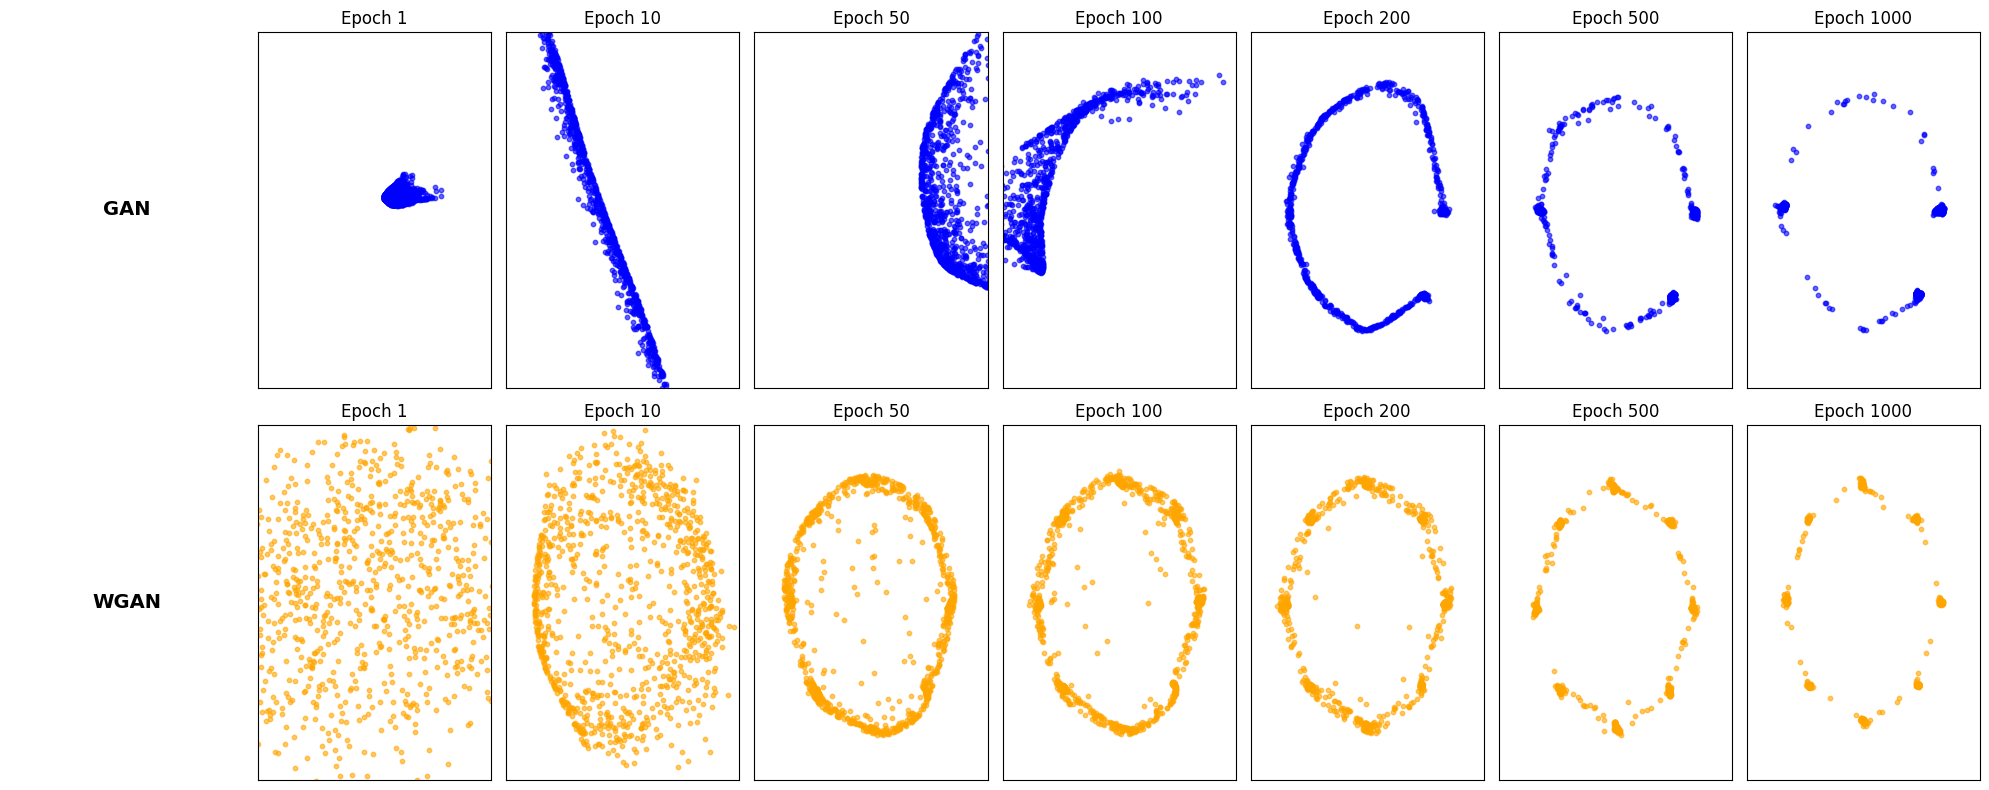


Generating loss curves...


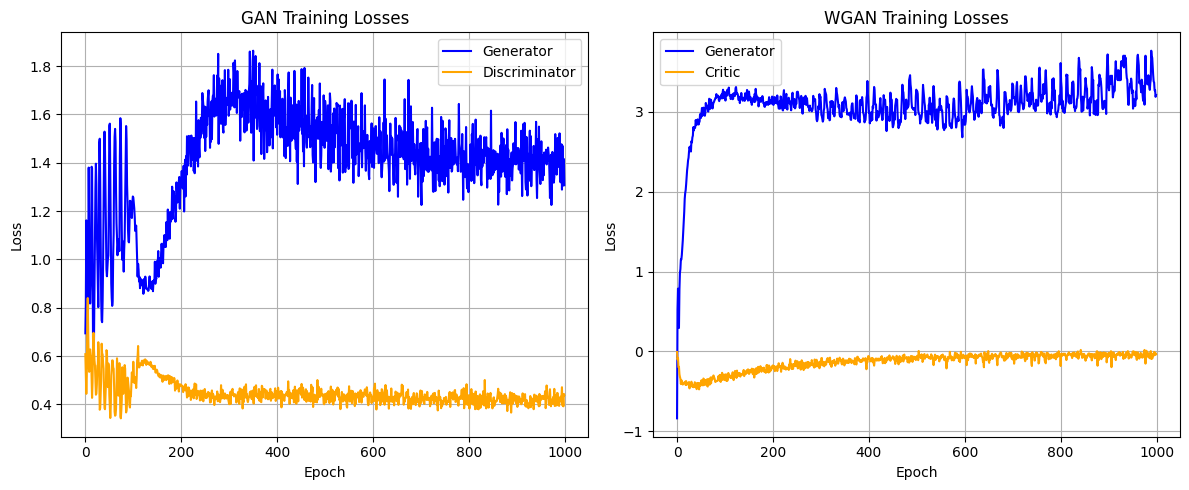

In [8]:
gan_G = MLP_G().to(device)
gan_D = MLP_D().to(device)
wgan_G = MLP_G().to(device)
wgan_D = MLP_D().to(device)

gan_losses = train_gan(gan_G, gan_D, loader)
wgan_losses = train_wgan(wgan_G, wgan_D, loader)

print("Generating sample evolution visualization...")
create_sample_evolution_figure(
    gan_samples=gan_losses[2],
    wgan_samples=wgan_losses[2]
)

print("\nGenerating loss curves...")
plot_loss_curves(
    gan_losses=(gan_losses[0], gan_losses[1]),
    wgan_losses=(wgan_losses[0], wgan_losses[1])
)